In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Example: A Simple Linear Model for Air Quality

Recall from  {numref}`Chapter %s <ch:pa>` that our aim is to use air quality measurements from the accurate Air Quality System  (AQS) sensors operated by the US government to predict the measurements made by PurpleAir (PA) sensors.  The pairs of data values come from neighboring instruments that measure the average daily concentration of particulate matter in the air on the same day. (The unit of measurement is an average count of particles under 2.5 mm in size per cubic liter of air in a 24-hour period.) In this section, we focus on air quality measurements at one location in Georgia. These are a subset of the data we examined in the case study in {numref}`Chapter %s <ch:pa>`. The measurements are daily averages from August 2019 to mid-November 2019:

In [2]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1']

full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa']

GA = full.loc[(full['id'] == 'GA1') , :]

from sklearn.linear_model import LinearRegression

In [3]:
GA

,date,id,region,pm25aqs,pm25pa
5258,2019-08-02,GA1,Southeast,8.65,16.19
5259,2019-08-03,GA1,Southeast,7.70,13.59
5260,2019-08-04,GA1,Southeast,6.30,10.30
...,...,...,...,...,...
5439,2019-10-18,GA1,Southeast,6.30,12.94
5440,2019-10-21,GA1,Southeast,7.50,13.62
5441,2019-10-30,GA1,Southeast,5.20,14.55


The feature `pm25aqs` contains measurements from the AQS sensor and `pm25pa` from the PurpleAir monitor. Since we are interested in studying how well the AQS measurements predict the PurpleAir measurements, our scatter plot places PurpleAir readings on the y-axis and AQS readings on the x-axis. We also add a trend line: 

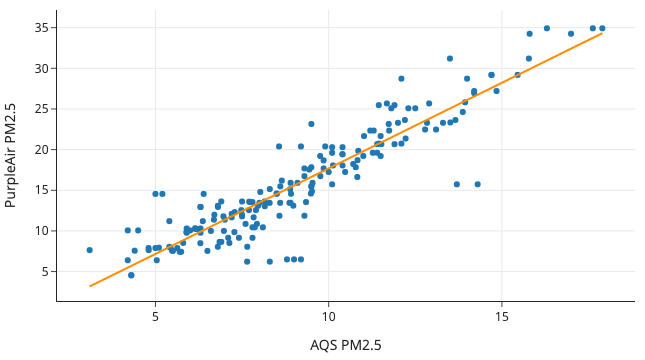

In [3]:
px.scatter(GA, x="pm25aqs", y="pm25pa", trendline='ols',
           trendline_color_override="darkorange",
           labels={'pm25aqs':'AQS PM2.5', 'pm25pa':'PurpleAir PM2.5'},
           width=350, height=250)

This scatter plot shows a linear relationship between the measurements from these two kinds of instruments. The model that we want to fit has the following form:

$$ PA \approx \theta_0 + \theta_1 AQ$$

where $PA$ refers to the  PurpleAir average daily measurement and $AQ$ to its partner AQS measurement.

Since `pandas.Series` objects have built-in methods to compute SDs and correlation coefficients, we can quickly define functions that calculate the best-fitting line:

In [4]:
def theta_1(x, y):
    r = x.corr(y)
    return r * y.std() / x.std()

In [5]:
def theta_0(x, y):
    return y.mean() - theta_1(x, y) * x.mean()

Now we can fit the model by computing
$\hat{\theta}_0$ and $\hat{\theta}_1$ for these data:

In [6]:
t1 = theta_1(GA['pm25aqs'], GA['pm25pa'])
t0 = theta_0(GA['pm25aqs'], GA['pm25pa'])

In [7]:
print(f'Model: {t0:.2f} + {t1:.2f}AQ')

Model: -3.36 + 2.10AQ


This model matches the trend line shown in the scatter plot. That's not by accident. The parameter value for `trendline` in the call to `scatter()` is `"ols"`, which stands for *ordinary least squares*, another name for fitting a linear model by minimizing squared error.

Let's examine the errors. 
First, we find the predictions for PA measurements given the AQS measurements, and 
then we calculate the errors---the difference between the actual PA measurements and the predictions:

In [7]:
prediction = t0 + t1 * GA["pm25aqs"]
error = GA["pm25pa"] - prediction
fit = pd.DataFrame(dict(prediction=prediction, error=error))

Let's plot these errors against the predicted values:

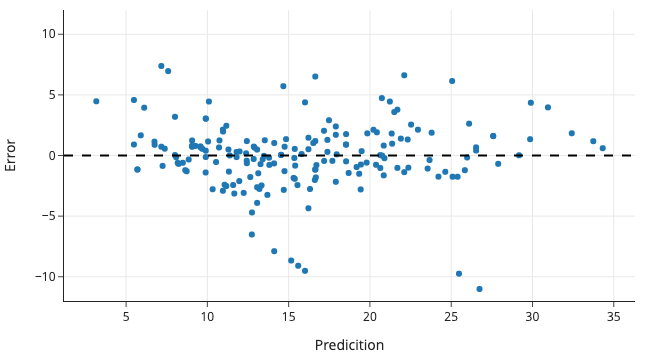

In [14]:
fig = px.scatter(fit, y='error', x='prediction',
                 labels={"prediction":"Predicition","error":"Error"},
                 width=350, height=250)

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)

fig.update_yaxes(range=[-12, 12])
fig.show()

An error of 0 means that the actual measurement falls on the fitted line; we also call this line the *least squares line* or the *regression line*. A positive value means it is above the line, and negative means it's below. You might be wondering how good this model is and what it says about our data. We consider these topics next. 

## Interpreting Linear Models

The original scatter plot of paired measurements shows that the PurpleAir recordings are often quite a bit higher than the more accurate AQS measurements. Indeed, the equation for our simple line model has a slope of about 2.1. We interpret the slope to mean that a change of 1 ppm measured by the AQS monitor is associated with a 2 ppm change in the PA measurement, on average. So, if on one day the AQS sensor measures 10 ppm and on the next day it is 5 ppm higher, namely 15 ppm, then our prediction for the PA measurement increases from one day to the next by $2 * 5 = 10$ ppm.

Any change in the PurpleAir reading is not caused by the change in the AQS reading. Rather, they both reflect the air quality, and our model captures the relationship between the two devices. Oftentimes, the term *prediction* is taken to mean *causation*, but that is not the case here. Instead, the prediction just refers to our use of the *linear association* between PA and AQS measurements.

As for the intercept in the model, we might expect it to be 0, since when there is no particulate matter in the air we would think that both instruments would measure 0 ppm. But for an AQS of 0, the model predicts $-3.4$ ppm for PurpleAir, which doesn't make sense. There can't be negative amounts of particles in the air. This highlights the problem of using the model outside the range where measurements were taken. We observed AQS recordings between 3 and 18 ppm, and in this range the model fits well. While it makes sense for the line to have an intercept of 0, such a model doesn't fit well in a practical sense and the predictions tend to be much worse.

George Box, a renowned statistician, famously said, "All models are wrong, but some are useful." Here is a case where despite the intercept of the line not passing through 0, the simple linear model is useful in predicting  air quality measurements for a PurpleAir sensor. Indeed, the correlation between our two features is very high:  

In [17]:
GA.corr()

,pm25aqs,pm25pa
pm25aqs,1.00,0.92
pm25pa,0.92,1.00


Aside from looking at correlation coefficients, there are other ways to assess the quality of a linear model.

## Assessing the Fit

The earlier plot of the errors against the fitted values gives a visual assessment of the quality of the fit. (This plot is called a  *residual plot* because the errors are sometimes referred to as *residuals*.) A good fit should show a cloud of points around the horizontal line at 0 with no clear pattern. When there is a pattern, we can usually conclude that the simple linear model doesn't entirely capture the signal. We saw earlier that there are no apparent patterns in the residual plot. 

Another type of residual plot that can be useful is a plot of the residuals against a feature that is not in the model. If we see a pattern, then we may want to include this feature in the model, in addition to the feature(s) already in the model. Also, when the data have a time component, we want to check for patterns in the residuals over time. For these particular data, since the measurements are daily averages over a four-month period, we plot the error against the date the measurement is recorded:   

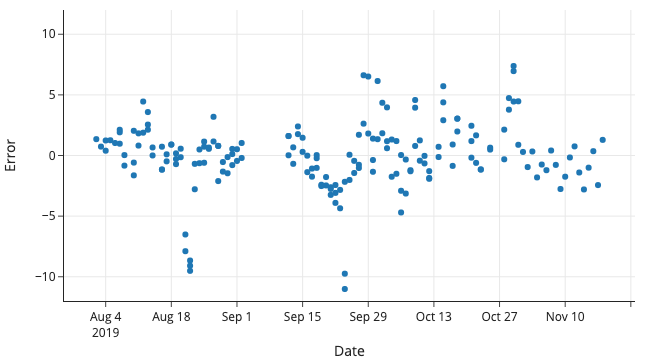

In [15]:
fig = px.scatter(x= GA["date"], y=error, 
            labels={"x":"Date","y":"Error"}, width=400, height=250)

fig.update_yaxes(range=[-12, 12])
fig

It looks like there are a few consecutive days near the end of August and again near the end of September where the data are far below what is expected. Looking back at the original scatter plot (and the first residual plot), we can see two small clusters of horizontal points below the main point cloud. The plot we just made indicates that we should check the original data and any available information about the equipment to determine whether it was properly functioning on those days.

The residual plot can also give us a general sense of how accurate
the model is in its predictions.
Most of the errors lie between $\pm 6 $ ppm of the line.
And we find the standard deviation of the errors to be about 2.8 ppm:

In [16]:
error.std()

2.796095864304746

In comparison, the standard deviation of the PurpleAir measurements is quite a bit larger:

In [41]:
GA['pm25pa'].std()

6.947418231019878

The model error may be further reduced if we find the monitor wasn't working on those days in late August and September and exclude them from the dataset. In any event, for situations where the air is quite clean, the error is relatively large, but in absolute terms it is inconsequential. We are typically more concerned about the case when there is air pollution, and in that case, an error of 2.8 ppm seems reasonable.  

Let's return to the process of how to find this line, the process of *model fitting*. In the next section, we derive the intercept and slope by minimizing the mean squared error. 